In [729]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Exercício 1


## 1.1)
Escrevemos uma rotina que resolva sistemas de equações lineares pelo método de Gauss com pivotage parcial.

In [730]:
def gauss_solve(A, v):
    A, v = np.array(A, float), np.array(v, float)
    n = len(A)
    epsilon = 1e-12
    index = np.arange(n)
    for i in range(n):
        d = A[index[i], i]
        if d > epsilon:
            A[index[i], i:] /= d
        elif i < n - 1:
            j = 0
            while d < epsilon:
                j += 1
                index[i], index[i+j] = index[i+j], index[i]
                d = A[index[i], i]
            A[index[i], i:] /= d
        v[index[i]] /= d
        for j in range(i + 1, n):
            m = A[index[j], i]
            if m > epsilon:
                A[index[j],:] -= A[index[i],:] * m
                v[index[j]] -= v[index[i]] * m
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[index[i]] = v[index[i]]
        for j in range(i + 1, n):
            x[index[i]] -=  A[index[i], j]*x[index[j]]
    return x
#Nota, não tive tempo de reparar um bug em que o resultado tem elementos trocados em ordem 2 a 2.

## 1.2)
Temos o seguinte sistema de equações:

$$m_{i} \frac{d^{2} X_{i}}{d t^{2}}=-k_{i}\left(X_{i}-X_{i-1}\right)+k_{i+1}\left(X_{i+1}-X_{i}\right)$$

sendo $X_o = 0$ e $X_{N + 1} = L$.

A condição de equilíbrio implica $$\frac{d^{2} X_{i}}{d t^{2}} = 0$$.

De onde obtemos o sistema de equações:
Com 
$$ -k_{i}\left(X_{i}-X_{i-1}\right)+k_{i+1}\left(X_{i+1}-X_{i}\right) = 0 $$.

Concluímos imediatamente que a matrix será uma tridiagonal, sendo que cada massa so interage com os seus vizinhos.

Trabalhamos em unidades normalizadas de k e L.

Implementamos então um método para resolver matrizes tridiagonais.
*Nota:* Este método pode não ser capaz de resolver casos particulares em que surgem zeros na diagonal, por exemplo. Contudo, insistiremos na sua utilização quando possível, visto escalar com $O(n)$ em vez de $O(n^3)$ da eliminação Gaussiana, que utilizariamos no caso de o método tridiagonal não funcionar.

In [731]:
def tridiag(l, d, u, v): #lower, diagonal, upper, vector
    n = len(d)
    x = np.empty(n, float)
    for i in range(1, n):
        k = l[i - 1] / d[i - 1]
        d[i] -= k * u[i - 1]
        v[i] -= k * v[i - 1]
    x[n - 1] = v[n -1] / d[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = (v[i] - u[i] * x[i + 1]) / d[i]
    return x

*i)* Se as massa são iguais, temos o sistema:

$$\left(X_{i}-X_{i-1}\right)+\left(X_{i+1}-X_{i}\right) = 0$$

A matriz dos coeficientes é então:

$$\left( \matrix{ -k_0 - k_1 & k_1 & 0 \cr
k_1 & -k_1 - k_2 & k_2 & \dots \cr
0 & k_2 & -k_2 -k_3 & \cr
& \vdots & &  \ddots & } 
\right)$$

Simplificando no caso de k todos iguais para:

$$\left( \matrix{- 2k & k& 0 & \dots \cr
k &- 2k & k \cr
0 & k & -2k & \cr
& \vdots & &  \ddots & } 
\right)$$

Construímos um método que construa a matriz (neste caso os vetores correspondentes à matriz tridiagonal) dos coeficientes.

In [732]:
def get_coeffs(n, ks): #diag
    l, u = ks[1:-1], ks[1:-1]
    d = np.empty(n, float)
    d[:-1] = -ks[:-2] - ks[1:-1]
    d[-1] = -ks[-2] - ks[-3]
    v = np.zeros(n)
    v[-1] = - ks[-1]
    return l, d, u, v

Para o caso de k's todos iguais, temos:

In [733]:
n, k = 9, 1
ks = np.ones(n + 1) * k
l, d, u, v = get_coeffs(n, ks)
print(tridiag(l, d, u, v))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


Confirmamos que as massas, em equilíbrio, se distribuem uniformemente pelo em $[0, L]$, sendo o espaçamento entre elas $\frac{1}{N + 1}$, tal como esperado.

## 1.3)
O estado de equilíbrio do sistema não depende das massas. Isto deve-se ao facto de impormos $$\frac{d^{2} X_{i}}{d t^{2}} = 0$$ com ocondição de equilíbrio.

Assim, as distâncias entre massa, em equilíbrio é igual: $\frac{1}{(N + 1)}$.

## 1.4)
Geramos agora uma distribuição normal de k's, com $ \left< k \right> = 1$ e $\sigma = 0.1$.

[0.00128728 0.00207358 0.00291987 ... 1.03995885 1.04107679 1.04210599]


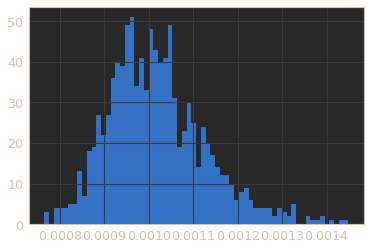

In [734]:
n = 2 ** 10
ks = np.random.normal(1, .1, n + 1)
l, d, u, v = get_coeffs(n, ks)
pos = tridiag(l, d, u, v)
print(pos)
diff = pos[1:] - pos[:-1]
plt.hist(diff, bins=2**6)
plt.show()

Verificamos que as distâncias são distribuidas (quase) normalmente, o que não choca com a intuição.

## 1.5)
### 1.5.a)
Usamos a mudança de variável $ x_i = X_i - X_{eq}$.

No caso de massas iguais, reduzimos o sistema de equações à forma:

$$\frac{d^{2} x_{i}}{d t^{2}}=A_{i j} x_{j}$$

Sendo

$$ A = \left( \matrix{ -k_0 - k_1 & k_1 & 0 \cr
k_1 & -k_1 - k_2 & k_2 & \dots \cr
0 & k_2 & -k_2 -k_3 & \cr
& \vdots & &  \ddots & } 
\right)$$

Já que $m_i = m$ e $\frac{d^{2} X_{eq}}{d t^{2}}=0$.

Pretendemos agora diagonalizar a matriz $A$. Para isso, utilizamos uma decomposição QR.

In [735]:
def QR_decomp(A, n):
    Q, R, U = np.zeros((n, n), float), np.zeros((n, n), float),np.zeros((n, n), float)
    U[:,0] = A[:,0]
    u_norms = np.empty(n, float)
    u_norms[0] = np.linalg.norm(U[:, 0])
    Q[:, 0] =  U[:, 0]/u_norms[0]
    for i in range(1, n):
        U[:, i] = A[:, i]
        for j in range(i):
            U[:, i] -= Q[:, j].dot(A[:, i]) * Q[:, j]
        u_norms[i] = np.linalg.norm(U[:, i])
        Q[:,i] = U[:, i]/u_norms[i]
    for i in range(n):
        for j in range(i + 1, n):
            R[i, j] = Q[:, i].dot(A[:, j])
        R[i, i] = u_norms[i]
    return Q, R

In [736]:
def eigen(A, epsilon = 1e-12):
    n = len(A)
    V = np.identity(n, float)
    diag = False
    while not diag:
        diag = True
        Q, R = QR_decomp(A, n)
        A = np.dot(R, Q)
        V = np.dot(V, Q)
        if abs(A.sum() - np.diag(A).sum()) > epsilon:
            diag = False
    return np.diag(A), V

Implementamos agora a k's aleatórios:

In [737]:
n = 10
ks = np.random.normal(1, .1, n + 1)
l, d, u, v = get_coeffs(n, ks)
A = np.diag(d) + np.diag(l, k=-1) + np.diag(l, k=1)
B = np.copy(A)
Xeq = tridiag(l, d, u, v)
L, U = eigen(A)
L = -np.absolute(L)
print("Valores próprios")
print(L)
print("Vetores próprios")
for u in U:
    print(u)

Valores próprios
[-3.86539824 -3.55501327 -3.15444274 -2.70305834 -2.2480819  -1.63929066
 -1.12691994 -0.66678313 -0.30593244 -0.07699898]
Vetores próprios
[-0.16304834 -0.22355027 -0.286113   -0.39166183 -0.47001331 -0.45556578
 -0.3538515  -0.28337587 -0.20635036 -0.10786545]
[ 0.33163598  0.37909049  0.3603035   0.30058841  0.12771186 -0.17841276
 -0.3361293  -0.41126019 -0.38060856 -0.22586236]
[-0.45745544 -0.37825173 -0.15752967  0.13170356  0.37691213  0.34277896
  0.04040467 -0.26175912 -0.42205557 -0.31250166]
[ 0.46896581  0.16369973 -0.20322975 -0.39359817 -0.20028629  0.32791674
  0.38475331  0.0647268  -0.33768848 -0.37835096]
[-0.43848325  0.13055947  0.4153531   0.15844907 -0.34134584 -0.24692303
  0.29731231  0.36453995 -0.14115262 -0.41757197]
[ 0.36466792 -0.35376509 -0.2833207   0.25846498  0.27554426 -0.39130009
 -0.11193219  0.40864044  0.08551065 -0.4229947 ]
[-0.26538777  0.46363739 -0.0920724  -0.38140625  0.28876227  0.13843565
 -0.4263544   0.16468689  0.3065

### 1.5.b)

Mudando para coordenadas:

$$f_{\beta}=U_{\beta i}^{T} x_{i}$$

Sendo $U$ a matriz de vetores próprios. Temos a condição:

$$f_{\beta}=A_{\beta} e^{t \sqrt{\lambda_{\beta}}}+B_{\beta} e^{-t \sqrt{\lambda_{\beta}}}$$

Derivando

$$ f_{\beta}'= \sqrt{\lambda_{\beta}}  A_{\beta} e^{t \sqrt{\lambda_{\beta}}} - \sqrt{\lambda_{\beta}}B_{\beta} e^{-t \sqrt{\lambda_{\beta}}}$$

Impondo a condição de velocidades iniciais nulas:

$$ f_{\beta}'= A_{\beta}-B_{\beta} = 0 \Rightarrow A_{\beta} = B_{\beta}$$

As equações de evolução do sistema são então

$$ x_{i}=U_{i \beta} A_{\beta} \left[ e^{t \sqrt{\lambda_{\beta}}}+e^{-t \sqrt{\lambda_{\beta}}} \right] $$

Para $t = 0$

$$ x_{i} (0)= 2 U_{i \beta} A_{\beta}$$


In [738]:
x0 = np.random.uniform(-1/2/(n + 1), 1/2/(n + 1), n)
A = sp.solve(2*U, x0)
print(A)

[ 0.00508643  0.00994442  0.01339858 -0.01587982  0.00885366  0.00503999
  0.00545342 -0.01038098  0.00477308 -0.00730311]


### 1.5.c)
Representado no tempo a evolução do sistema nas condições anteriores

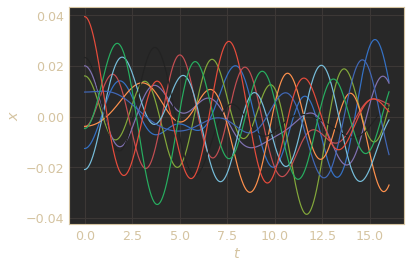

In [750]:
ts = np.linspace(0, 16, 1000)
Xs = np.zeros((n, len(ts)), float)
for i in range(n):
    xs = .0 * ts
    for j, t in enumerate(ts):
        E = 2 * np.cos(t * np.sqrt(-L))
        xs[j] = U[i,:].dot(A*E)
    Xs[i] = Xeq[i] + xs
    plt.plot(ts, xs)
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.show()

Somando as posições de equilĩbrio, obtemos as posições reais das massas.

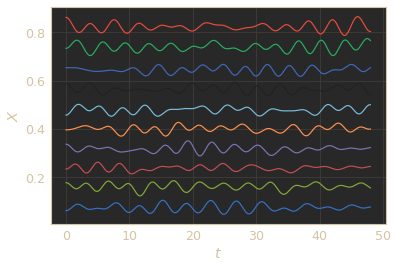

In [740]:
for i in range(n):
    plt.plot(ts, Xs[i])
plt.xlabel(r"$t$")
plt.ylabel(r"$X$")
plt.show()

# Exercício 2
## 2.1)

Aplicamos agora uma força externa ao sistema, obtendo equações de movimento

$$ m \frac{d^{2} x_{i}}{d t^{2}}=-k_{i}\left(x_{i}-x_{i-1}\right)+k_{i+1}\left(x_{i+1}-x_{i}\right)+\delta_{i l} F e^{i \Omega t-\gamma|t|} $$

Por uma transformada de Fourier, obtemos

$$-m \omega^{2} x_{i}(\omega)=-k_{i}\left(x_{i}(\omega)-x_{i-1}(\omega)\right)+k_{i+1}\left(x_{i+1}(\omega)-x_{i}(\omega)\right)+\frac{2 \gamma F}{\gamma^{2}+(\omega-\Omega)^{2}} \delta_{i l}$$

Que analisaremos para o caso $\Omega = \omega$ e $ \tilde{F} = 2 \frac{F}{\gamma}$. Normalizando para $\tilde{F} = 1$, $l = 1$ e $m = 1$ as equações reduzem a:

$$-m \omega^{2} x_{i}(\omega)=-k_{i}\left(x_{i}(\omega)-x_{i-1}(\omega)\right)+k_{i+1}\left(x_{i+1}(\omega)-x_{i}(\omega)\right)+ \tilde{F} \delta_{i l}$$

E a respetiva matriz de coeficientes é

$$ A = \left( \matrix{ -k_0 - k_1 + \omega^2 & k_1 & 0 \cr
k_1 & -k_1 - k_2 + \omega^2 & k_2 & \dots \cr
0 & k_2 & -k_2 -k_3 + \omega^2 & \cr
& \vdots & &  \ddots & } 
\right)$$

In [741]:
def get_coeffs2(n, ks, w): #diag
    l, u = ks[1:-1], ks[1:-1]
    d = np.empty(n, float)
    d[:-1] = -ks[:-2] - ks[1:-1] + w**2
    d[-1] = -ks[-2] - ks[-3] + w**2
    v = np.zeros(n)
    v[0] = -1
    return l, d, u, v

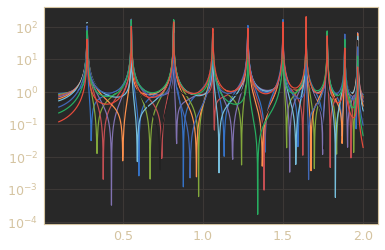

In [742]:
ws = np.linspace(.1, 2, 1000)
xs = np.zeros((n, len(ws)), float)
for j, w in enumerate(ws):
    l, d, u, v = get_coeffs2(n, ks, w)
    xs[:, j] = tridiag(l, d, u, v)
for i in range(n):
    plt.plot(ws, np.absolute(xs[i,:]))
plt.yscale("log")
plt.show()

As curvas têm os mesmos máximos nas posições de ressonância, correspondentes aos picos visíveis da figura. A amplitude máxima depende da constante da mola $k_i$.

## 2.2) 
Desenhamos no gráfico $\sqrt{-\lambda_i}$.

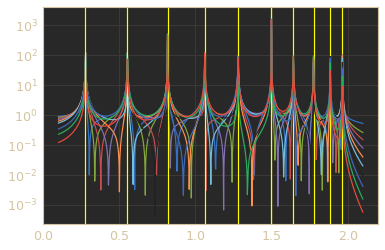

In [743]:
ws = np.linspace(.1, 2.1, 1000)
xs = np.zeros((n, len(ws)), float)
for j, w in enumerate(ws):
    l, d, u, v = get_coeffs2(n, ks, w)
    xs[:, j] = tridiag(l, d, u, v)
for i in range(n):
    Ls = np.sqrt(-L)
    plt.plot(ws, np.absolute(xs[i,:]))
    plt.axvline(x = Ls[i], color = "yellow")
plt.yscale("log")
plt.show()

Verificamos que as frequências de ressonância correspondem às dos modos normais do sistema. Isto é o comportamento esperado, pois quando forçamos o sistema a oscilar segundo um dos seus modos normais é quando ocorre o fenómeno de ressonância.

## 2.3)
Fazemos a seguinte transformação:

$$f_{\beta}=U_{\beta i}^{T} x_{i} = U_{i \beta}x_{i}$$

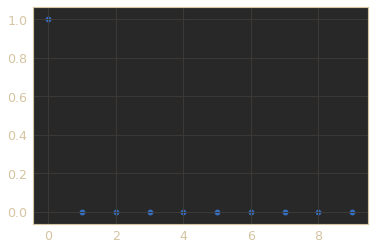

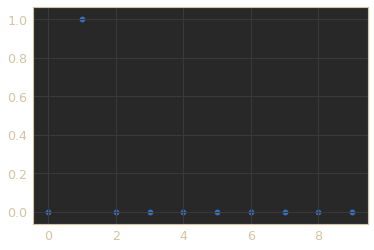

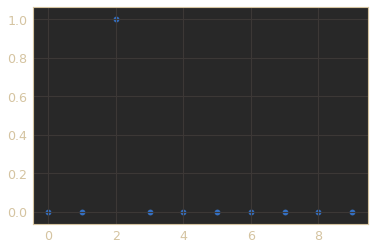

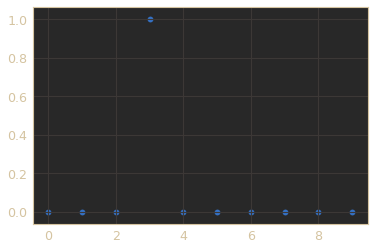

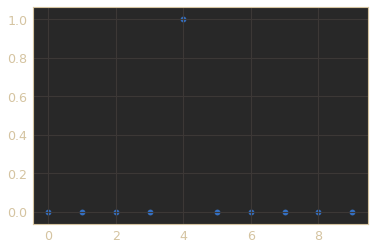

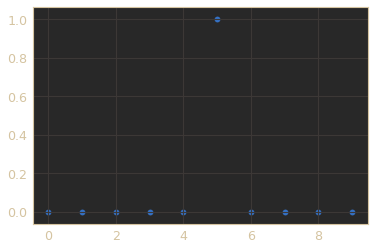

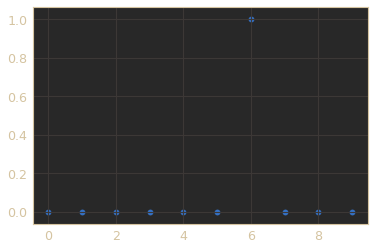

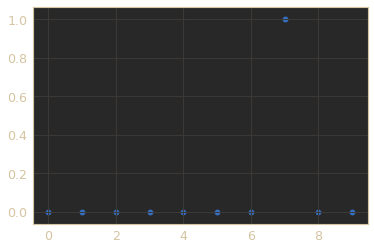

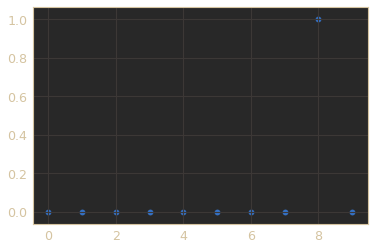

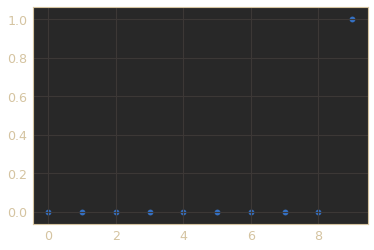

In [744]:
fs = np.zeros((n, n))
for i in range(n):
    l, d, u, v = get_coeffs2(n, ks, Ls[i])
    Xs = tridiag(l, d, u, v)
    fs[i] = np.transpose(U).dot(Xs/np.linalg.norm(Xs))
    plt.scatter(np.arange(n),np.absolute(fs[i]))
    plt.show()

Verificamos assim que nos pontos de ressonância, o sistema oscila segundo apenas uma das coordenadas associadas à transformação.
Este é o comportamento esperado.

## 2.4)
Adicionamos agora uma força na décima massa tal que $F_{9} = -F_{0}$. Resolvemos de novo o sistema:

In [745]:
def get_coeffs3(n, ks, w): #diag
    l, u = ks[1:-1], ks[1:-1]
    d = np.empty(n, float)
    d[:-1] = -ks[:-2] - ks[1:-1] + w**2
    d[-1] = -ks[-2] - ks[-3] + w**2
    v = np.zeros(n)
    v[0] = -1
    v[-1] = 1
    return l, d, u, v

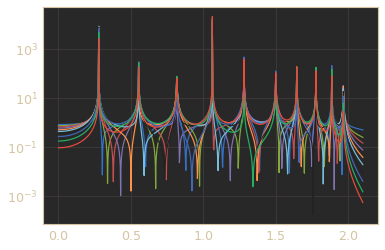

In [746]:
ws = np.linspace(0, 2.1, 1000)
xs = np.zeros((n, len(ws)), float)
for j, w in enumerate(ws):
    l, d, u, v = get_coeffs2(n, ks, w)
    xs[:, j] = tridiag(l, d, u, v)
for i in range(n):
    plt.plot(ws, np.absolute(xs[i,:]))
plt.yscale("log")
plt.show()

Não são percetíveis diferenças significativas no comportamento de ressonância so sistema. Contudo, se escolhermos k's distribuidos com menor variância, obtemos:

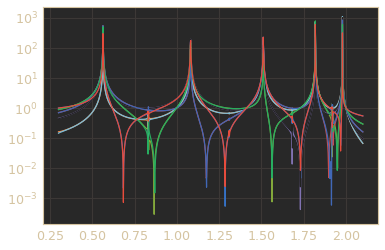

In [747]:
kss = np.random.normal(1, .001, n + 1)
ws = np.linspace(.3, 2.1, 1000)
xs = np.zeros((n, len(ws)), float)
for j, w in enumerate(ws):
    l, d, u, v = get_coeffs3(n, kss, w)
    xs[:, j] = tridiag(l, d, u, v)
for i in range(n):
    plt.plot(ws, np.absolute(xs[i,:]))
plt.yscale("log")
plt.show()

Onde vemos um número menor de frequências de ressonância.
Isto deve-se ao facto de, como as forças têm sentido inverso, e são aplicadas simetricamente nos extremos do sistema, têm efeito de anular os modos de ressonância nos termos ímpares.

Confirmamos esta hipótese com o seguinte gráfico, onde realçamos os pontos de ressonância pares ou impares:

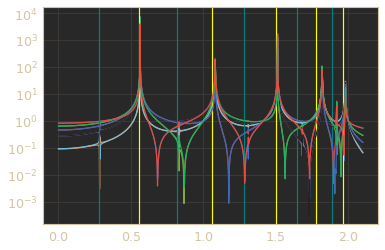

In [748]:
ws = np.linspace(0, 2.1, 1000)
xs = np.zeros((n, len(ws)), float)
for j, w in enumerate(ws):
    l, d, u, v = get_coeffs3(n, kss, w)
    xs[:, j] = tridiag(l, d, u, v)
for i in range(n):
    Ls = np.sqrt(-L)
    plt.plot(ws, np.absolute(xs[i,:]))
    if i % 2 == 0:
        plt.axvline(x = Ls[i], color = "yellow")
    else:
        plt.axvline(x = Ls[i], color = "teal")
plt.yscale("log")
plt.show()